## 0. Import thư viện

In [1]:
from datasets import load_dataset
from PIL import Image
import re
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from datetime import datetime

import torch
import torch.nn as nn
from torchvision import transforms
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader

from transformers import AutoProcessor, BlipForConditionalGeneration
from tqdm import tqdm

import nltk
from nltk.translate.bleu_score import corpus_bleu

/home/khahao/venv_hao/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-03 18:13:34.326305: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 18:13:34.363613: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-03 18:13:35.488003: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different n

## 1. Tải Dataset Flickr8k từ Hugging Face

In [2]:
ds = load_dataset("jxie/flickr8k")
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'caption_0', 'caption_1', 'caption_2', 'caption_3', 'caption_4'],
        num_rows: 6000
    })
    validation: Dataset({
        features: ['image', 'caption_0', 'caption_1', 'caption_2', 'caption_3', 'caption_4'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image', 'caption_0', 'caption_1', 'caption_2', 'caption_3', 'caption_4'],
        num_rows: 1000
    })
})


## 2. Tiền xử lý Captions

In [3]:
def clean_caption(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9' ]+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [4]:
def flatten_dataset(split):
    items = []
    for row in tqdm(ds[split], desc=f"Flatten {split}"):
        for i in range(5):
            items.append({
                "image": row["image"],
                "caption": clean_caption(row[f"caption_{i}"])
            })
    return items

train_clean = flatten_dataset("train")
val_clean   = flatten_dataset("validation")
test_clean  = flatten_dataset("test")

Flatten test: 100%|██████████| 1000/1000 [00:01<00:00, 547.75it/s]


## 8. Inference

In [ ]:
# Setup device và load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load best model for inference
print("\nLoading best model...")

model = BlipForConditionalGeneration.from_pretrained("./best_model").to(device)
print("Best model loaded successfully!")
processor = AutoProcessor.from_pretrained("./best_model")

# Tạo Flickr8k vocabulary constraint
print("\n📚 Creating Flickr8k vocabulary constraint...")

# Tạo vocab từ training data
flickr_vocab = set()
for item in train_clean:   
    ids = processor.tokenizer(item["caption"], add_special_tokens=False).input_ids
    flickr_vocab.update(ids)
flickr_vocab = sorted(list(flickr_vocab))
eos_id = processor.tokenizer.sep_token_id

print(f"✅ Flickr8k vocab size: {len(flickr_vocab)} tokens")
print(f"✅ EOS token ID: {eos_id}")

Using device: cuda

Loading best model...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Best model loaded successfully!


In [ ]:
from transformers.generation.logits_process import LogitsProcessor

class FlickrVocabLogitsProcessor(LogitsProcessor):
    def __init__(self, vocab_ids, eos_id):
        self.vocab_ids = sorted(list(vocab_ids) + [eos_id])  # đảm bảo eos_id luôn được phép

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor) -> torch.FloatTensor:
        # scores: [batch_size, vocab_size]
        mask = torch.full_like(scores, float('-inf'))  
        mask[:, self.vocab_ids] = 0                   
        return scores + mask

flickr_logits_processor = FlickrVocabLogitsProcessor(flickr_vocab, eos_id)

def generate_caption_beam(image, model, processor, device, max_length=50, beam_size=5, use_vocab_constraint=True):
    """Generate caption using beam search with optional Flickr8k vocab constraint"""
    model.eval()
    
    if isinstance(image, str):
        image = Image.open(image).convert("RGB")
    
    inputs = processor(images=image, return_tensors="pt").to(device)
    
    # Prepare generation arguments
    generation_kwargs = {
        **inputs,
        "max_length": max_length,
        "num_beams": beam_size,
        "no_repeat_ngram_size": 3,
        "early_stopping": True,
        "length_penalty": 1.0,
    }
    
    # Add vocab constraint if enabled
    if use_vocab_constraint:
        generation_kwargs["logits_processor"] = [flickr_logits_processor]
    
    with torch.no_grad():
        generated_ids = model.generate(**generation_kwargs)
    
    caption = processor.decode(generated_ids[0], skip_special_tokens=True)
    return caption

In [ ]:
# Beam Search Inference on Test Set với Flickr8k vocab constraint
print("🚀 Running Beam Search Inference with Flickr8k Vocab Constraint")
print("=" * 70)

# Tạo lại test data với id và 5 references cho mỗi ảnh từ dataset gốc
test_data_with_refs = []
for idx, row in enumerate(tqdm(ds["test"], desc="Preparing test data")):
    # Lấy 5 references gốc (đã clean)
    refs = []
    for i in range(5):
        refs.append(clean_caption(row[f"caption_{i}"]))
    
    test_data_with_refs.append({
        "id": idx,  # Thêm id để tracking
        "image": row["image"],
        "references": refs  # 5 references cho mỗi ảnh
    })

print(f"📊 Test set: {len(test_data_with_refs)} images với 5 references mỗi ảnh")
print(f"🔒 Using Flickr8k vocabulary constraint: {len(flickr_vocab)} tokens")

# Inference
results = []  # Sẽ chứa dict với id, predicted, ground_truth

# Run inference with vocab constraint
for item in tqdm(test_data_with_refs, desc="Generating captions (vocab constrained)"):
    img_id = item["id"]
    img = item["image"]
    refs = item["references"]
    
    # Generate prediction với vocab constraint
    pred = generate_caption_beam(
        img, model, processor, device, 
        use_vocab_constraint=True  # Enable Flickr8k vocab constraint
    )
    
    # Store results với format cho evaluation
    results.append({
        "id": img_id,
        "predicted": pred,
        "ground_truth": refs,  # Danh sách 5 references
        "image": img  # Lưu image để visualization
    })

# Save results
inference_data = {
    "results": results,
    "total_images": len(results),
    "vocab_constrained": True,
    "vocab_size": len(flickr_vocab)
}

with open("beam_inference_results_vocab_constrained.json", "w") as f:
    # Không lưu image object vào JSON, chỉ lưu text data
    save_data = {
        "results": [
            {
                "id": r["id"],
                "predicted": r["predicted"], 
                "ground_truth": r["ground_truth"]
            } for r in results
        ],
        "total_images": len(results),
        "vocab_constrained": True,
        "vocab_size": len(flickr_vocab)
    }
    json.dump(save_data, f, indent=2)

print("💾 Results saved to: beam_inference_results_vocab_constrained.json")
print(f"📊 Total predictions: {len(results)}")
print(f"🔒 Vocabulary constraint: ENABLED ({len(flickr_vocab)} tokens)")

🚀 Running Beam Search Inference on Test Set


Preparing test data: 100%|██████████| 1000/1000 [00:01<00:00, 617.04it/s]


📊 Test set: 1000 images với 5 references mỗi ảnh


Generating captions: 100%|██████████| 1000/1000 [03:24<00:00,  4.88it/s]

💾 Results saved to: beam_inference_results.json
📊 Total predictions: 1000


🧪 VISUALIZATION: 5 SAMPLE IMAGES WITH CAPTIONS


/tmp/ipykernel_17772/810824697.py:31: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_17772/810824697.py:31: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_17772/810824697.py:32: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.savefig('sample_captions_visualization.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_17772/810824697.py:32: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  plt.savefig('sample_captions_visualization.png', dpi=300, bbox_inches='tight')
/home/khahao/venv_hao/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/khahao/venv_hao/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaV

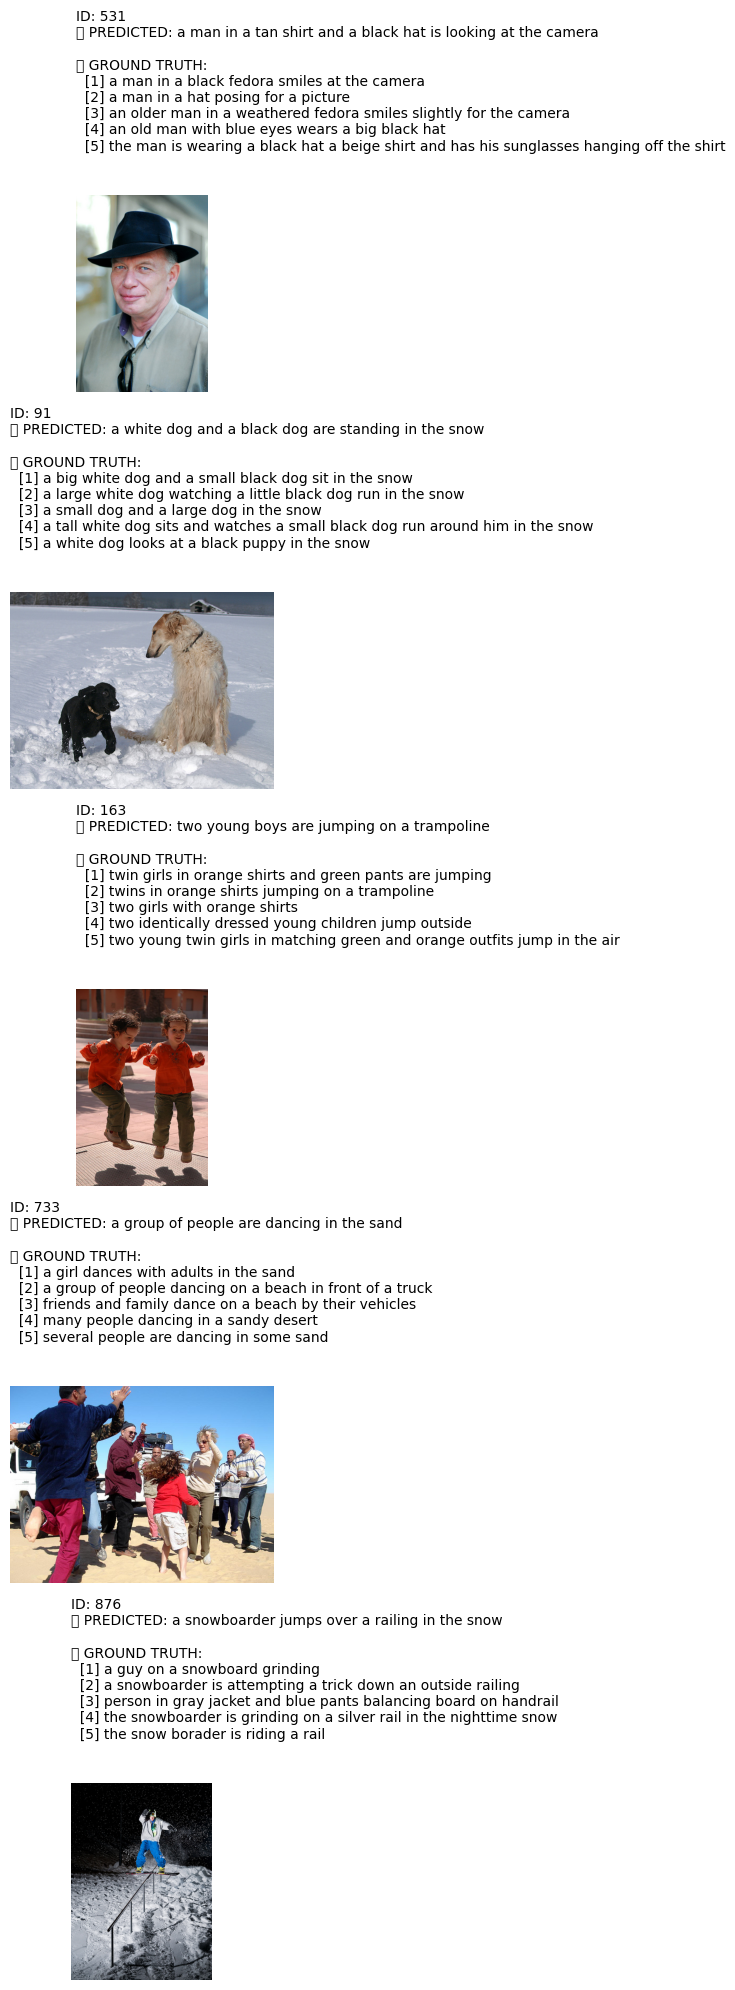

💾 Visualization saved as: sample_captions_visualization.png


In [9]:
# Trực quan 5 ảnh bất kỳ với captions
print("🧪 VISUALIZATION: 5 SAMPLE IMAGES WITH CAPTIONS")
print("=" * 70)

# Chọn 5 ảnh ngẫu nhiên
import random
sample_indices = random.sample(range(len(results)), 5)

# Tạo subplot
fig, axes = plt.subplots(5, 1, figsize=(15, 20))

for i, idx in enumerate(sample_indices):
    result = results[idx]
    img = result["image"]
    predicted = result["predicted"]
    references = result["ground_truth"]
    
    # Hiển thị ảnh
    axes[i].imshow(img)
    axes[i].axis('off')
    
    # Tạo title với predicted và references
    title = f"ID: {result['id']}\n"
    title += f"🤖 PREDICTED: {predicted}\n\n"
    title += "📝 GROUND TRUTH:\n"
    for j, ref in enumerate(references):
        title += f"  [{j+1}] {ref}\n"
    
    axes[i].set_title(title, fontsize=10, ha='left', loc='left', pad=20)

plt.tight_layout()
plt.savefig('sample_captions_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Visualization saved as: sample_captions_visualization.png")

## 9. Đánh giá mô hình

In [10]:
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.meteor.meteor import Meteor

In [11]:
def evaluate_captions(results):
    """
    Đánh giá captions với format mới:
    - results: list of dict với keys: id, predicted, ground_truth (list of references)
    """
    # Chuẩn bị data cho pycocoevalcap format
    gts = {}  # ground truth: {id: [ref1, ref2, ...]}
    res = {}  # predictions: {id: [predicted]}
    
    for result in results:
        img_id = str(result["id"])  # Convert to string for consistency
        gts[img_id] = result["ground_truth"]  # List of 5 references
        res[img_id] = [result["predicted"]]   # List với 1 prediction
    
    # Initialize scorers
    bleu_scorer = Bleu(4)
    cider_scorer = Cider()
    meteor_scorer = Meteor()
    rouge_scorer = Rouge()
    
    # Compute scores
    bleu_score, _ = bleu_scorer.compute_score(gts, res)
    cider_score, _ = cider_scorer.compute_score(gts, res)
    meteor_score, _ = meteor_scorer.compute_score(gts, res)
    rouge_score, _ = rouge_scorer.compute_score(gts, res)
    
    return {
        "BLEU-1": bleu_score[0],
        "BLEU-2": bleu_score[1], 
        "BLEU-3": bleu_score[2],
        "BLEU-4": bleu_score[3],
        "CIDEr": cider_score,
        "METEOR": meteor_score,
        "ROUGE-L": rouge_score
    }

# Đánh giá mô hình
print("🔄 Evaluating model performance...")
scores = evaluate_captions(results)

print("\n" + "="*50)
print("📊 EVALUATION RESULTS")
print("="*50)
for metric, value in scores.items():
    print(f"{metric:12s}: {value:.4f}")
print("="*50)

# Lưu scores
with open("evaluation_scores.json", "w") as f:
    json.dump(scores, f, indent=2)
    
print("💾 Scores saved to: evaluation_scores.json")

🔄 Evaluating model performance...
{'testlen': 10040, 'reflen': 9919, 'guess': [10040, 9040, 8040, 7040], 'correct': [7525, 4189, 2104, 984]}
ratio: 1.012198810363846

📊 EVALUATION RESULTS
BLEU-1      : 0.7495
BLEU-2      : 0.5893
BLEU-3      : 0.4496
BLEU-4      : 0.3357
CIDEr       : 0.9444
METEOR      : 0.2678
ROUGE-L     : 0.5619
💾 Scores saved to: evaluation_scores.json

📊 EVALUATION RESULTS
BLEU-1      : 0.7495
BLEU-2      : 0.5893
BLEU-3      : 0.4496
BLEU-4      : 0.3357
CIDEr       : 0.9444
METEOR      : 0.2678
ROUGE-L     : 0.5619
💾 Scores saved to: evaluation_scores.json
